# Détection des lignes d'un terrain de foot

Ce projet s'inscrit dans le cadre du cours de traitement d'image pour la robotique. L'objectif de ce travail est de développer des algorithmes capables de détecter de manière (plus ou moins) fiable les lignes d'un terrain de football. Cette capacité trouve son application pour les robots de l'équipe Robhan, qui participent à la RoboCup.

Les images utilisées pour entraîner et évaluer nos modèles proviennent directement des caméras embarquées sur les robots de Robhan durant. Le défi réside dans le traitement et l'analyse de ces images (éventuellement en temps réel) pour assurer une interprétation rapide de l'environnement de jeu, permettant ainsi aux robots de prendre des décisions sans intervention humaine.

Dans ce notebook, nous explorerons le processus de création, d'entraînement et d'évaluation de modèles de deep learning, en particulier des réseaux de neurones convolutifs (CNN), pour la tâche spécifique de détection des lignes sur le terrain. Nous verrons également comment coupler ces méthodes à des algorithmes de traitement d'image classique et comparerons ces résultats

## Importation des librairies nécessaires

In [3]:
import os
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        # La croissance de la mémoire doit être définie avant l'initialisation des GPU
        print(e)
import numpy as np
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.preprocessing.image import img_to_array, load_img, ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import TensorBoard
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import cv2


2023-12-11 21:34:06.797109: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-11 21:34:06.956281: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-11 21:34:06.956314: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-11 21:34:06.957035: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-11 21:34:07.018519: I tensorflow/core/platform/cpu_feature_g

## I. Création d'un modèle de type U-Net

Le modèle U-Net est une architecture de réseau de neurones convolutifs profonds qui a été conçue spécifiquement pour la tâche de segmentation d'images. L'architecture U-Net est caractérisée par sa structure en forme de U, qui comprend un chemin contractant (encodeur) pour capturer le contexte et un chemin symétrique expansif (décodeur) qui permet une localisation précise.

### Architecture du modèle

Notre implémentation U-Net est structurée comme suit :

- **Bloc de convolution** : chaque bloc effectue deux convolutions 3x3 suivies par des activations ReLU et un dropout de 0.2 pour la régularisation.
- **Encodeur** : chaque bloc de l'encodeur est composé d'un bloc de convolution suivi d'une couche de max-pooling 2x2 pour réduire les dimensions spatiales.
- **Pont** : au fond de l'U, un bloc de convolution sert de pont entre l'encodeur et le décodeur.
- **Décodeur** : chaque bloc du décodeur commence par une opération d'upsampling 2x2, suivi d'une concaténation avec les caractéristiques correspondantes de l'encodeur et d'un autre bloc de convolution.
- **Sortie** : la dernière couche est une convolution 1x1 avec une activation 'sigmoid' pour la segmentation binaire ou 'softmax' pour la segmentation multiclasse. Nous ne nous somme au final pas aventuré à tenter la segmentation multiclasse.

Nous avons défini une fonction de perte combinée pour l'entraînement. Combinant la cross-entropy binaire avec le coefficient de Dice pour une meilleure performance et stabilité du gradient, elle permet un gain de précision du modèle de l'ordre de 20%. 

Le coefficient de Dice sert également de métrique pour évaluer la qualité de la segmentation (et sauvgarder le modèle via callback).


In [5]:
power_mul = 3

def conv_block(input_tensor, num_filters):
    tensor = Conv2D(num_filters, (3, 3), padding='same')(input_tensor)
    tensor = tf.keras.layers.Activation('relu')(tensor)
    tensor = Conv2D(num_filters, (3, 3), padding='same')(tensor)
    tensor = tf.keras.layers.Activation('relu')(tensor)
    tensor = Dropout(0.2)(tensor)
    return tensor

def encoder_block(input_tensor, num_filters):
    x = conv_block(input_tensor, num_filters)
    p = MaxPooling2D((2, 2))(x)
    return x, p

def decoder_block(input_tensor, concat_tensor, num_filters):
    x = UpSampling2D((2, 2))(input_tensor)
    x = Concatenate()([x, concat_tensor])
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape, num_classes):
    inputs = Input(input_shape)

    # Encoder
    x1, p1 = encoder_block(inputs, 2**(0+power_mul))
    x2, p2 = encoder_block(p1, 2**(1+power_mul))
    x3, p3 = encoder_block(p2, 2**(2+power_mul))
    x4, p4 = encoder_block(p3, 2**(3+power_mul))

    # Pont
    b = conv_block(p4, 2**(4+power_mul))

    # Decoder
    d1 = decoder_block(b, x4, 2**(3+power_mul))
    d2 = decoder_block(d1, x3, 2**(2+power_mul))
    d3 = decoder_block(d2, x2, 2**(1+power_mul))
    d4 = decoder_block(d3, x1, 2**(0+power_mul))

    # Output
    if num_classes == 1:  # Seuillage binaire
        activation = 'sigmoid'
    else:  # Seuillage multiclasse
        activation = 'softmax'

    outputs = Conv2D(num_classes, (1, 1), activation=activation)(d4)

    model = Model(inputs, outputs)
    return model


def dice_metric(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)
    
    return (numerator + 1) / (denominator + 1)

def combined_loss(y_true, y_pred):
    return 0.5 * binary_crossentropy(y_true, y_pred) + 0.5 * (1 - dice_metric(y_true, y_pred))


# Build du model
input_shape = (448, 768, 3)  # Le model fonctionne mieux avec des images dont la taille est un multiple de 2^4 et/ou 2^5
num_classes = 1
model = build_unet(input_shape, num_classes)

# Compile the model
model.compile(optimizer='adam', loss=combined_loss, metrics=['accuracy', dice_metric])

# Model summary
model.summary()

# model total parameters
total_params = model.count_params()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 448, 768, 3)]        0         []                            
                                                                                                  
 conv2d_19 (Conv2D)          (None, 448, 768, 8)          224       ['input_2[0][0]']             
                                                                                                  
 activation_18 (Activation)  (None, 448, 768, 8)          0         ['conv2d_19[0][0]']           
                                                                                                  
 conv2d_20 (Conv2D)          (None, 448, 768, 8)          584       ['activation_18[0][0]']       
                                                                                            

## II. Préparation des données

La phase de préparation des données est essentielle à la performance de tout modèle de deep learning. Dans notre cas, elle consiste à charger, traiter et augmenter un ensemble d'images et de masques correspondants qui serviront à entraîner et valider notre modèle de détection de lignes sur un terrain de football.

### Processus de préparation des données

Nous suivons les étapes suivantes pour préparer nos données :

- **Chargement des données** : Nous commençons par charger des images de terrains de football ainsi que leurs masques correspondants.
- **Redimensionnement** : Les images et les masques sont redimensionnés pour correspondre aux dimensions d'entrée requises par notre modèle U-Net.
- **Augmentation des données** : Afin de renforcer la robustesse de notre modèle et (essayer) d'éviter l'overfitting, nous augmentons notre ensemble de données en appliquant des transformations aléatoires, telles que la rotation, le décalage, le cisaillement et le zoom.
- **Partitionnement des données** : Les données sont divisées en ensembles d'entraînement et de validation avec une répartition de 80/20. Cela nous permet d'entraîner notre modèle sur une grande partie des données tout en réservant une portion pour évaluer sa performance.
- **Normalisation** : Les images et les masques sont normalisés pour que leurs valeurs soient comprises entre 0 et 1, ce qui améliore la convergence pendant l'entraînement.

A noter que cette cellule permet le chargement des données pour les deux méthodes que nous détailleront dans les cellules suivante, le réseaux de neuronnes servant dans un premier cas à masquer le terrain et dans le second cas, à detecter directement des lignes par segmentation.

### Limitation

Etant donné que l'ensemble de test est très homogène (images très ressemblantes les unes avec les autres) il est très difficile d'éviter ou même de mesurer l'overfitting de notre modèle.


In [6]:
nb_mul = 5

def resize_images(dataset, new_size=(448, 768)):
    resized_dataset = []
    for image in dataset:
        resized_image = tf.image.resize(image, new_size)
        resized_dataset.append(resized_image)
    return np.array(resized_dataset)

def create_extended_dataset(images, masks, augment=True, batch_size=32):
    global nb_mul
    # Définition des paramètres de l'augmentation
    data_gen_args = dict(
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # Creation du générateur aléatoire
    if augment:
        image_datagen = ImageDataGenerator(**data_gen_args)
        mask_datagen = ImageDataGenerator(**data_gen_args)
    else:
        image_datagen = ImageDataGenerator()
        mask_datagen = ImageDataGenerator()
    
    seed = 1
    image_generator = image_datagen.flow(images, batch_size=batch_size, seed=seed, shuffle=False)
    mask_generator = mask_datagen.flow(masks, batch_size=batch_size, seed=seed, shuffle=False)
    
    augmented_images = []
    augmented_masks = []

    # Iteration pour générer les images augmentées
    for _ in range(nb_mul*(len(images) // batch_size)):
        img_batch, mask_batch = next(image_generator), next(mask_generator)
        augmented_images.extend(img_batch)
        augmented_masks.extend(mask_batch)

    # Concaténation des images augmentées avec les images originales
    combined_images = np.concatenate([images, np.array(augmented_images)], axis=0)
    combined_masks = np.concatenate([masks, np.array(augmented_masks)], axis=0)

    return combined_images, combined_masks



def load_images_from_folder(mask_folder, img_folder):
    masks = []
    images = []
    for filename in os.listdir(mask_folder):
        m = load_img(os.path.join(mask_folder,filename), color_mode='grayscale')
        m = img_to_array(m)
        try:
            i = load_img(os.path.join(img_folder, filename), color_mode='rgb')
            i = img_to_array(i)

        except FileNotFoundError:
            print("The specified file does not exist.")
        if i is not None and m is not None:
            masks.append(m)
            images.append(i)

    return masks, images

def load_data(type_label):
    # Chargement masque pour ligne
    mask_dir = "./labels_"+type_label
    img_dir = "./videos"

    masks, images = load_images_from_folder(mask_dir+"/log1", img_dir+"/log1")

    logaddm, logaddi = load_images_from_folder(mask_dir+"/log2", img_dir+"/log2")
    masks += logaddm
    images += logaddi

    logaddm, logaddi = load_images_from_folder(mask_dir+"/log3", img_dir+"/log3")
    masks += logaddm
    images += logaddi

    logaddm, logaddi = load_images_from_folder(mask_dir+"/log4", img_dir+"/log4")
    masks += logaddm
    images += logaddi

    images = np.array(images, dtype="float32")
    masks = np.array(masks, dtype="float32")

    # Normalization des images et des masques pour avoir des valeurs entre 0 et 1
    images /= 255.0
    masks /= 255.0

    return images, masks


# Type de données à charger : line / terrain
type_label = "line"


# Chargement des données
# Si les données n'ont pas déjà été sauvegardées, on les charge et on les sauvegarde
if not os.path.isfile("dataset/X_train_"+type_label+"_"+str(nb_mul)+".npy"):
    images, masks = load_data(type_label)
    # Resize images and masks
    images = resize_images(images)
    masks = resize_images(masks)

    # Augment the data
    images, masks = create_extended_dataset(images, masks, augment=True, batch_size=33)
    # Split the data
    X_train, X_val, y_train, y_val = train_test_split(images, masks, test_size=0.2, random_state=42)

    
    # Check the shape of the loaded data
    X_train.shape, y_train.shape, X_val.shape, y_val.shape

    #save X and y
    np.save("dataset/X_train_"+type_label+"_"+str(nb_mul), X_train)
    np.save("dataset/y_train_"+type_label+"_"+str(nb_mul), y_train)
    np.save("dataset/X_val_"+type_label+"_"+str(nb_mul), X_val)
    np.save("dataset/y_val_"+type_label+"_"+str(nb_mul), y_val)
else:
    X_train = np.load("dataset/X_train_"+type_label+"_"+str(nb_mul)+".npy")
    y_train = np.load("dataset/y_train_"+type_label+"_"+str(nb_mul)+".npy")
    X_val = np.load("dataset/X_val_"+type_label+"_"+str(nb_mul)+".npy")
    y_val = np.load("dataset/y_val_"+type_label+"_"+str(nb_mul)+".npy")



## III. Entraînement du modèle

Une fois nos données préparées et prêtes, on passe à l'entrainement du modèle.

### Configuration de l'entraînement

Nous avons mis en place plusieurs éléments clés :

- **Réinitialisation de la Session Keras** : Nous commençons par réinitialiser la session de backend Keras pour nous assurer qu'aucun état résiduel ne perturbe notre processus d'entraînement.
- **Callbacks** :
  - **TensorBoard** : Un callback TensorBoard est configuré pour enregistrer des métriques d'entraînement, permettant ainsi une visualisation détaillée de la progression de l'entraînement.
  - **ModelCheckpoint** : Deux callbacks ModelCheckpoint sont utilisés pour sauvegarder le meilleur modèle en fonction de la précision de validation (`val_accuracy`) et du coefficient de Dice de validation (`val_dice_metric`). Cela nous permet de conserver le modèle qui performe le mieux sur l'ensemble de validation et comparer les deux métriques.
- **Entraînement** : Le modèle est entraîné en utilisant la méthode `fit()` de Keras, avec un nombre spécifié d'époques, une taille de lot et nos callbacks.
- **Sauvegarde du modèle final** : Après l'entraînement, le modèle est sauvegardé pour une utilisation ultérieure. Il s'avère en réalité que le modèle sauvgardé à la fin de l'entrainement est systématiquement inférieur en terme de performance aux modèles sauvgardés via les callbacks.

### Observation et ajustement

Une fois l'entraînement terminé, nous pouvons utiliser TensorBoard pour examiner les courbes d'apprentissage, vérifier les problèmes potentiels comme l'overfitting et effectuer des ajustements si nécessaire.


In [75]:
tf.keras.backend.clear_session()

tensorboard_callback = TensorBoard(log_dir='./logs/'+type_label+"_"+str(total_params), histogram_freq=1)

checkpoint_acc = ModelCheckpoint(
    'acc_model_'+type_label+'_'+str(total_params)+'_.h5',  # chemin où sauvegarder le modèle
    monitor='val_accuracy',  # métrique à surveiller
    verbose=1,  # afficher des messages détaillés
    save_best_only=True,  # sauvegarder uniquement le meilleur modèle
    mode='max'  # Sauvegarder le modèle avec la meilleure accuracy
)

checkpoint_dice = ModelCheckpoint(
    'dice_model_'+type_label+'_'+str(total_params)+'_.h5',  # chemin où sauvegarder le modèle
    monitor='val_dice_metric',  # métrique à surveiller
    verbose=1,  # afficher des messages détaillés
    save_best_only=True,  # sauvegarder uniquement le meilleur modèle
    mode='max'  # Sauvegarder le modèle avec la meilleure accuracy
)

# Entraînement du modèle
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=2,
    epochs=20,
    verbose=1,
    callbacks=[checkpoint_acc, checkpoint_dice, tensorboard_callback]
)

# Sauvegarde du modèle
model.save('unet.h5')

# free VRAM
import gc
del model
gc.collect()



Epoch 1/20


2023-12-11 12:11:51.234195: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


64/64 [==============================] - ETA: 0s - loss: 0.4907 - accuracy: 0.7148 - dice_metric: 0.6587
Epoch 1: val_accuracy improved from -inf to 0.76318, saving model to acc_model_terrain_491137_.h5

Epoch 1: val_dice_metric improved from -inf to 0.85419, saving model to dice_model_terrain_491137_.h5
64/64 [==============================] - 5s 28ms/step - loss: 0.4907 - accuracy: 0.7148 - dice_metric: 0.6587 - val_loss: 0.2368 - val_accuracy: 0.7632 - val_dice_metric: 0.8542
Epoch 2/20
61/64 [===========================>..] - ETA: 0s - loss: 0.2259 - accuracy: 0.8082 - dice_metric: 0.8720
Epoch 2: val_accuracy improved from 0.76318 to 0.92499, saving model to acc_model_terrain_491137_.h5

Epoch 2: val_dice_metric improved from 0.85419 to 0.92165, saving model to dice_model_terrain_491137_.h5
64/64 [==============================] - 2s 24ms/step - loss: 0.2206 - accuracy: 0.8138 - dice_metric: 0.8759 - val_loss: 0.1401 - val_accuracy: 0.9250 - val_dice_metric: 0.9216
Epoch 3/20
64/6

8994

## IV. Méthode 1 : Masquage du terrain

Dans cette section, nous déployons la première méthode de notre projet qui consiste à masquer d'abord le terrain pour ensuite détecter les lignes de ce dernier. Cette approche est basée sur l'hypothèse que l'identification et l'exclusion des zones non pertinentes du terrain peuvent améliorer la précision de la détection des lignes.

### Processus de masquage

Le processus de masquage suit ces étapes :

- **Chargement des Modèles** : Nous chargeons deux modèles entraînés précédemment - un optimisé pour l'accuracy (`acc_model`) et l'autre pour le coefficient de Dice (`dice_model`). Après comparaison, le `dice_model` s'avère être plus efficace et précis.
- **Préparation de l'Image** : L'image est chargée, redimensionnée, et normalisée pour s'adapter aux dimensions d'entrée du modèle.
- **Prédiction des Masques** : Nous utilisons le modèle pour prédire le masque du terrain.
- **Post-traitement** : Le masque prédit subis des opérations morphologiques (érosion et dilatation) pour améliorer sa qualité. Un seuil est ensuite appliqué pour obtenir un masque binaire net.

### Détection des lignes

Avec le masque binaire en main, nous procédons à la détection des lignes :

- **Application du Masque** : Le masque est appliqué à l'image originale pour isoler les lignes du terrain.
- **Post-traitement des Images Masquées** : L'images masquées est soumise à des opérations de traitement d'image pour mettre en évidence les lignes.
- **Comparaison avec les Labels** : L'images traitée est comparée au label pour évaluer la qualité de la détection des lignes, en utilisant le coefficient de Dice comme métrique.
- **Visualisation** : Nous affichons l'image originale, le masque prédit, l'image après application du masque et le résultat de la détection des lignes, ainsi que l'image label pour une comparaison visuelle.

### Conclusion

Cette méthode de masquage du terrain suivie par la détection des lignes montre comment une approche ciblée peut améliorer la précision de la segmentation. Cette méthode s'avère cependant très peu satisfaisante avec un taux de précision de l'ordre de ~10%




1/1 [==============================] - 0s 93ms/step


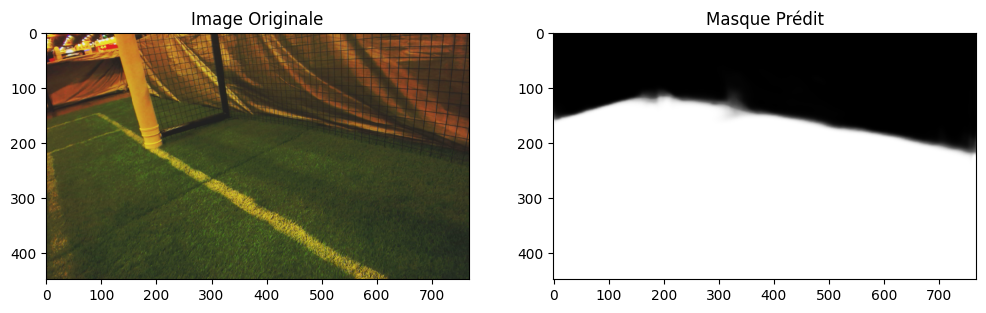

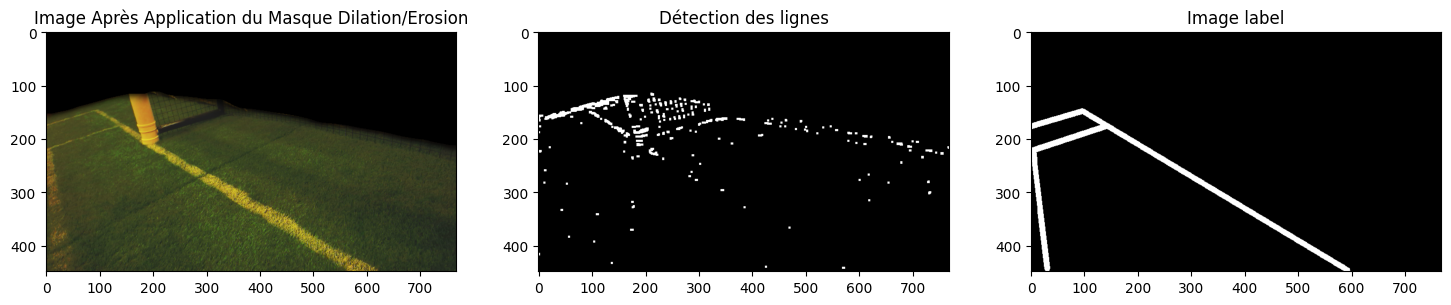

DICE score: 0.09706287287746673


In [36]:
from lines_detection import preprocess

# Charger le modèle
acc_model = tf.keras.models.load_model("acc_model_terrain_"+str(total_params)+"_.h5", custom_objects={'combined_loss': combined_loss, 'dice_metric': dice_metric})
dice_model = tf.keras.models.load_model("dice_model_terrain_"+str(total_params)+"_.h5", custom_objects={'combined_loss': combined_loss, 'dice_metric': dice_metric})

# Charger et préparer l'image
image_path = "./videos/log4/27-rgb.png"
image = load_img(image_path, target_size=(448, 768))  # Ajustez la taille selon votre modèle
image = img_to_array(image)
image = np.expand_dims(image, axis=0)  # Ajouter une dimension pour le batch
image = image / 255.0

# Prédire le masque
acc_predicted_mask = acc_model.predict(image)
dice_predicted_mask = dice_model.predict(image)
#deepcopy pour pouvoir modifier le masque sans modifier l'original
acc_unthresholded_mask = np.squeeze(acc_predicted_mask[0, ..., 0]).copy()
dice_unthresholded_mask = np.squeeze(dice_predicted_mask[0, ..., 0]).copy()

# Appliquer le masque à l'image originale (à ajuster selon votre cas d'utilisation)
# Par exemple, masquer l'image là où le masque est supérieur à un seuil
threshold = 0.25

# Convertir le masque prédit pour les opérations morphologiques
acc_mask_for_morphology = np.squeeze(acc_predicted_mask[0, ..., 0])
dice_mask_for_morphology = np.squeeze(dice_predicted_mask[0, ..., 0])

# Add gaussian blur befor morphological operations
acc_mask_for_morphology = cv2.GaussianBlur(acc_mask_for_morphology, (25, 25), 0)
dice_mask_for_morphology = cv2.GaussianBlur(dice_mask_for_morphology, (25, 25), 0)

# Définir un élément structurant pour les opérations morphologiques
kernel = np.ones((20, 20), np.uint8)

# Appliquer l'érosion et la dilatation
acc_eroded_mask = cv2.erode(acc_mask_for_morphology, kernel, iterations=1)
dice_eroded_mask = cv2.erode(dice_mask_for_morphology, kernel, iterations=1)
acc_dilated_mask = cv2.dilate(acc_eroded_mask, kernel, iterations=1)
dice_dilated_mask = cv2.dilate(dice_eroded_mask, kernel, iterations=1)

# Appliquer le seuil après les opérations morphologiques
acc_dilated_mask[acc_dilated_mask > threshold] = 1
dice_dilated_mask[dice_dilated_mask <= threshold] = 0

# Appliquer le masque morphologiquement amélioré à l'image
acc_masked_image_with_morphology = image[0] * np.expand_dims(acc_dilated_mask, axis=-1)
dice_masked_image_with_morphology = image[0] * np.expand_dims(dice_dilated_mask, axis=-1)


# threshold the mask
acc_predicted_mask[acc_predicted_mask > threshold] = 1
dice_predicted_mask[dice_predicted_mask > threshold] = 1
acc_predicted_mask[acc_predicted_mask <= threshold] = 0
dice_predicted_mask[dice_predicted_mask <= threshold] = 0
acc_masked_image = image[0] * acc_predicted_mask[0]
dice_masked_image = image[0] * dice_predicted_mask[0]

# Afficher l'image originale et l'image masquée
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Image Originale")
plt.imshow(image[0])

# afficher predicted_mask
plt.subplot(1, 2, 2)
plt.title("Masque Prédit")
plt.imshow(dice_unthresholded_mask, cmap='gray')
plt.show()

plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.title("Image Après Application du Masque Dilation/Erosion")
plt.imshow(dice_masked_image_with_morphology)

inferred_mask = cv2.cvtColor(dice_masked_image_with_morphology, cv2.COLOR_RGB2BGR)
inferred_mask = (inferred_mask * 255).astype(np.uint8)

processed_image = preprocess(inferred_mask)
plt.subplot(1, 3, 2)
plt.title("Détection des lignes")
plt.imshow(processed_image, cmap='gray')

label_image = load_img("labels_line/log4/27-rgb.png", color_mode='grayscale', target_size=(448, 768))
plt.subplot(1, 3, 3)
plt.title("Image label")
plt.imshow(label_image, cmap='gray')

plt.show()

intersection = np.sum(np.logical_and(processed_image, label_image))
union = np.sum(np.logical_or(processed_image, label_image))
print("DICE score:", (2.0 * intersection) / (union + intersection))



#### Calcul de l'efficacité de la méthode sur l'ensemble des données disponibles 

1/1 [==============================] - 0s 91ms/step
Average dice score: 0.11089993967097968


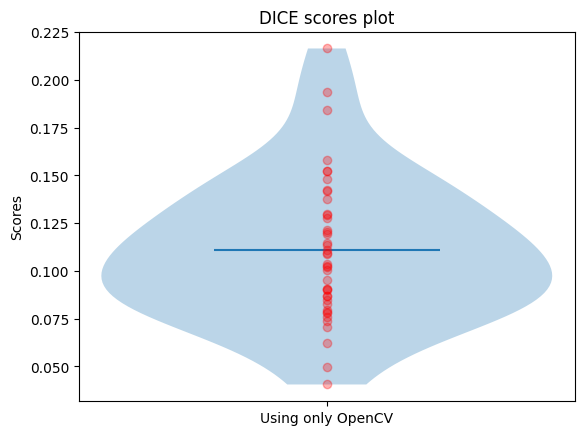

In [29]:
from pathlib import Path
from mask_predictor import MaskPredictor

scores = []

for i in range(1, 5):
    directory = "log" + str(i) + "/"
    files = list(Path("labels_terrain/" + directory).glob('*.png'))
    
    for index, file in enumerate(files):
        label_image = load_img("labels_terrain/" + directory + file.name, color_mode='grayscale', target_size=(448, 768))

        # Infer mask
        mask_predictor = MaskPredictor('dice_model_terrain_491137_.h5')

        # Traiter l'image et obtenir le masque
        inferred_mask = mask_predictor.process_image("./videos/" + directory + file.name, 0.8)
        inferred_mask = cv2.cvtColor(inferred_mask, cv2.COLOR_RGB2BGR)
        inferred_mask = (inferred_mask * 255).astype(np.uint8)

        processed_image = preprocess(inferred_mask)

        intersection = np.sum(np.logical_and(processed_image, label_image))
        union = np.sum(np.logical_or(processed_image, label_image))

        dice = (2.0 * intersection) / (union + intersection)
        scores.append(dice)

print("Average dice score:", sum(scores) / len(scores))

# Create a figure and axis
fig, ax = plt.subplots()

# Create a violin plot
violins = ax.violinplot(scores, showmeans=True, showextrema=False)

# Plot individual points on top of the violins
ax.plot(np.ones_like(scores) * 1, scores, 'ro', alpha=0.3)

# Set labels and title
ax.set_xticks([1])
ax.set_xticklabels(['Using only OpenCV'])
ax.set_ylabel('Scores')
ax.set_title('DICE scores plot')

# Show the plot
plt.show()

## V. Méthode 2 : Détection directe des lignes par segmentation

Dans cette deuxième méthode, nous abordons la détection des lignes de terrain de manière directe, en utilisant la segmentation pour identifier les lignes sans masquer au préalable d'autres parties du terrain. Cette approche vise à évaluer la capacité du modèle à isoler directement les lignes importantes du terrain à partir de l'image complète.

### Processus de détection directe

La procédure suivie est la suivante :

- **Chargement des Modèles** : Nous utilisons à nouveau deux modèles différents - l'un optimisé pour l'accuracy (`acc_model`) et l'autre pour le coefficient de Dice (`dice_model`). Cette comparaison nous permet d'évaluer laquelle de ces métriques optimise le mieux la performance pour la tâche spécifique de détection des lignes.
- **Préparation de l'Image** : L'image est chargée, redimensionnée pour correspondre aux dimensions d'entrée du modèle, et normalisée.
- **Prédiction des Masques** : Nous utilisons les modèles pour prédire les masques des lignes du terrain. Ces masques sont censés isoler les lignes du reste de l'image.
- **Seuillage des Masques** : Un seuil est appliqué aux masques prédits pour obtenir des images binaires, où les pixels blancs représentent les lignes et les pixels noirs le reste du terrain.

### Visualisation

Pour une évaluation visuelle :

- **Images Originales vs Masquées** : Nous affichons l'image originale à côté des images masquées obtenues par les deux modèles. Cela nous permet de comparer visuellement la qualité de la segmentation des lignes par les deux approches.
- **Masque Accuracy vs Masque Dice** : Les masques générés par les modèles optimisés pour l'accuracy et le coefficient de Dice sont affichés pour une comparaison directe. Cela nous aide à comprendre l'impact de l'optimisation de la métrique sur la qualité de la détection des lignes. On en conclue ainsi que le modèle dice est plus performant encore une fois.

Cette méthode montre une efficacité de l'ordre de ~70%


1/1 [==============================] - 0s 90ms/step


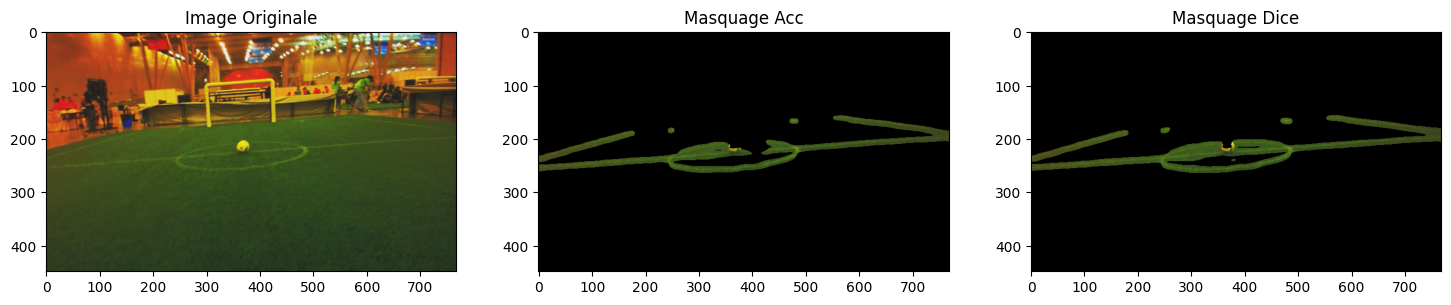

In [39]:
# Charger le modèle
acc_model = tf.keras.models.load_model("acc_model_line_"+str(total_params)+"_.h5", custom_objects={'dice_metric': dice_metric, 'combined_loss': combined_loss})
dice_model = tf.keras.models.load_model("dice_model_line_"+str(total_params)+"_.h5", custom_objects={'dice_metric': dice_metric, 'combined_loss': combined_loss})

# Charger et préparer l'image
image_path = "videos/log1/039-rgb.png"
image = load_img(image_path, target_size=(448, 768))  # Ajustez la taille selon votre modèle
image = img_to_array(image)
image = np.expand_dims(image, axis=0)  # Ajouter une dimension pour le batch
image = image / 255.0

# Prédire le masque
acc_predicted_mask = acc_model.predict(image)
dice_predicted_mask = dice_model.predict(image)
#deepcopy pour pouvoir modifier le masque sans modifier l'original
acc_unthresholded_mask = np.squeeze(acc_predicted_mask[0, ..., 0]).copy()
dice_unthresholded_mask = np.squeeze(dice_predicted_mask[0, ..., 0]).copy()

# Appliquer le masque à l'image originale (à ajuster selon votre cas d'utilisation)
# Par exemple, masquer l'image là où le masque est supérieur à un seuil
threshold = 0.25

# threshold the mask
acc_predicted_mask[acc_predicted_mask > threshold] = 1
dice_predicted_mask[dice_predicted_mask > threshold] = 1
acc_predicted_mask[acc_predicted_mask <= threshold] = 0
dice_predicted_mask[dice_predicted_mask <= threshold] = 0
acc_masked_image = image[0] * acc_predicted_mask[0]
dice_masked_image = image[0] * dice_predicted_mask[0]

# Afficher l'image originale et l'image masquée
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.title("Image Originale")
plt.imshow(image[0])

# afficher predicted_mask
plt.subplot(1, 3, 2)
plt.title("Masquage Acc")
plt.imshow(acc_masked_image)

plt.subplot(1, 3, 3)
plt.title("Masquage Dice")
plt.imshow(dice_masked_image)
plt.show()

#### Calcul de l'efficacité de la méthode sur l'ensemble des données de test

(448, 768, 3) (448, 768)
1/1 [==============================] - 0s 100ms/step
(448, 768, 3) (448, 768)
1/1 [==============================] - 0s 14ms/step
(448, 768, 3) (448, 768)
1/1 [==============================] - 0s 14ms/step
(448, 768, 3) (448, 768)
1/1 [==============================] - 0s 14ms/step
(448, 768, 3) (448, 768)
1/1 [==============================] - 0s 15ms/step
(448, 768, 3) (448, 768)
1/1 [==============================] - 0s 14ms/step
(448, 768, 3) (448, 768)
1/1 [==============================] - 0s 14ms/step
(448, 768, 3) (448, 768)
1/1 [==============================] - 0s 14ms/step
(448, 768, 3) (448, 768)
1/1 [==============================] - 0s 14ms/step
(448, 768, 3) (448, 768)
1/1 [==============================] - 0s 14ms/step
(448, 768, 3) (448, 768)
1/1 [==============================] - 0s 14ms/step
(448, 768, 3) (448, 768)
1/1 [==============================] - 0s 14ms/step
(448, 768, 3) (448, 768)
1/1 [==============================] - 0s 14ms/ste

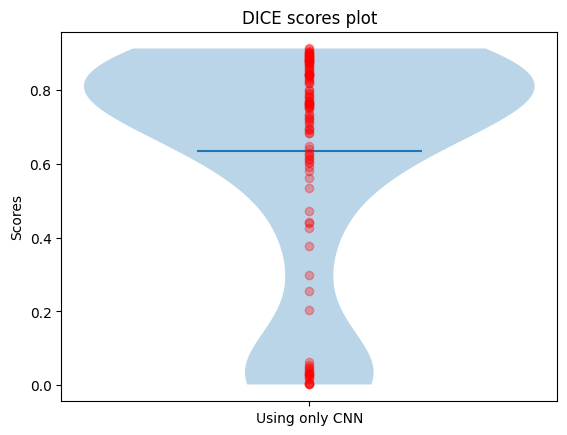

In [23]:
# Calcul du score DICE sur les images de test
model = tf.keras.models.load_model("dice_model_line_"+str(total_params)+"_.h5", custom_objects={'dice_metric': dice_metric, 'combined_loss': combined_loss})
scores = []

for i in range(len(X_val)):
    img = X_val[i]
    real_mask = y_val[i][..., 0]
    print(img.shape, real_mask.shape)
    # Charger l'image
    image = np.expand_dims(img, axis=0)
    # Prédire le masque
    predicted_mask = model.predict(image)
    # Appliquer le masque à l'image originale (à ajuster selon votre cas d'utilisation)
    # Par exemple, masquer l'image là où le masque est supérieur à un seuil
    """threshold = 0.25 
    predicted_mask[predicted_mask > threshold] = 1
    predicted_mask[predicted_mask <= threshold] = 0 """
    # Charger le masque réel
    # Calcul du score DICE
    dice = dice_metric(predicted_mask[0, ..., 0], real_mask)
    scores.append(dice)
    # plot real and predicted mask
"""     plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title("Real Mask")
    plt.imshow(real_mask, cmap='gray')
    plt.subplot(1, 2, 2)
    plt.title("Predicted Mask")
    plt.imshow(np.squeeze(predicted_mask[0, ..., 0]), cmap='gray')
    plt.show() """

print("Average dice score:", sum(scores) / len(scores))

# Create a figure and axis
fig, ax = plt.subplots()

# Create a violin plot
violins = ax.violinplot(scores, showmeans=True, showextrema=False)

# Plot individual points on top of the violins
ax.plot(np.ones_like(scores) * 1, scores, 'ro', alpha=0.3)

# Set labels and title
ax.set_xticks([1])
ax.set_xticklabels(['Using only CNN'])
ax.set_ylabel('Scores')
ax.set_title('DICE scores plot')

# Show the plot
plt.show()

## BONUS : Traitement Vidéo

En plus de la segmentation d'images individuelles, nous avons également exploré l'application de nos modèles de détection des lignes de terrain à des séquences vidéo. Cette extension permet d'évaluer la performance du modèle en conditions dynamiques et plus représentatives de l'environnement réel de la RoboCup.

### Processus de traitement vidéo

Pour traiter une vidéo avec notre modèle, nous suivons ces étapes :

- **Chargement du Modèle** : Nous chargeons le modèle optimisé pour le coefficient de Dice (`dice_model`). Ce modèle a montré de meilleures performances pour la détection des lignes dans nos tests précédents.
- **Ouverture de la Vidéo** : Nous ouvrons une vidéo enregistrée lors d'un match en utilisant OpenCV.
- **Traitement Frame par Frame** :
  - Pour chaque frame de la vidéo, nous la convertissons en format RGB, la redimensionnons et la normalisons.
  - Nous utilisons le modèle pour prédire le masque du terrain ou des lignes pour chaque frame.
  - Nous appliquons un seuil au masque prédit pour obtenir une segmentation binaire.
  - Le masque est ensuite utilisé pour modifier les pixels de la frame originale, par exemple, en rendant les lignes detectées rouges.
- **Affichage et Enregistrement** : Chaque frame traitée est par la suite affichée.

### Application et Visualisation

Cette méthode nous permet de visualiser directement les performances de notre modèle sur des vidéos, offrant ainsi une perspective plus complète sur son efficacité en temps réel.


In [38]:
# Charger le modèle
#model = tf.keras.models.load_model("dice_model_terrain_"+str(total_params)+"_.h5", custom_objects={'dice_metric': dice_metric, 'combined_loss': combined_loss})
model = tf.keras.models.load_model("dice_model_line_"+str(total_params)+"_.h5", custom_objects={'dice_metric': dice_metric, 'combined_loss': combined_loss})


# Ouvrir la vidéo
video_path = 'videos/log1.mp4'
cap = cv2.VideoCapture(video_path)
threshold = 0.6
kernel = np.ones((20, 20), np.uint8)

# Lire la vidéo frame par frame
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Convertir en RGB
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Redimensionner et normaliser la frame
    resized_frame = cv2.resize(frame, (768, 448))
    normalized_frame = resized_frame / 255.0
    normalized_frame = np.expand_dims(normalized_frame, axis=0)

    # Prédire le masque
    predicted_mask = model.predict(normalized_frame)

    # Appliquer les opérations morphologiques
    mask_for_morphology = np.squeeze(predicted_mask[0, ..., 0])
    # Add gaussian blur befor morphological operations
    mask_for_morphology[mask_for_morphology > threshold] = 1
    mask_for_morphology[mask_for_morphology <= threshold] = 0

    # Appliquer le masque à la frame pour que les pixels blancs du masque soient rouges dans la frame
    masked_frame = resized_frame.copy()

    """
    CHANGER LES COMMENTAIRES ICI EN FONCTION DU TYPE DE DONNÉES UTILISÉES
    """
    #masked_frame[mask_for_morphology == 0] = [0, 0, 0] # terrain
    masked_frame[mask_for_morphology == 1] = [255, 0, 0] # line

    # Convertir en format BGR pour OpenCV et remettre à l'échelle
    masked_frame = masked_frame.astype('uint8')  # Remettre à l'échelle et convertir en uint8

    # Convertir en BGR
    masked_frame = cv2.cvtColor(masked_frame, cv2.COLOR_RGB2BGR)

    # Afficher la frame masquée (ou enregistrer)
    cv2.imshow('Frame', masked_frame)
    #out.write(masked_frame)

    # Quitter avec 'q'
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Libérer les ressources
cap.release()
cv2.destroyAllWindows()


1/1 [==============================] - 0s 13ms/step
